In [21]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy
import os

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

In [2]:
import scFates as scf

In [3]:
import session_info
session_info.show()

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [5]:
sc.settings.set_figure_params(dpi=120, dpi_save=300, transparent=True)

In [6]:
%matplotlib inline

In [19]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Read in trajectory object

In [10]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Immune/MoMP_Aug2023/MultiVI-post_foetal_Mono-MP_withContCov-CCCov_13Mar2023_feature-select-0003.h5ad')

# rename obs_names
adata.obs_names = [x.replace('_expression','').replace('_paired','') for x in adata.obs_names]
adata

AnnData object with n_obs × n_vars = 7674 × 142283
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score', '_indices', '_scvi_batch', '_scvi_labels', 'fine_grain_withcycling', 't', 'seg', 'edge', 't_sd', 'milestones', 'fine_grain_mod'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'adata_auc_gene', 'adata_auc_region', 'adata_gex', 'adata_gex_lognorm', 'adata_peak_tfidf', 'dr

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'fine_grain_mod'}, xlabel='FA1', ylabel='FA2'>

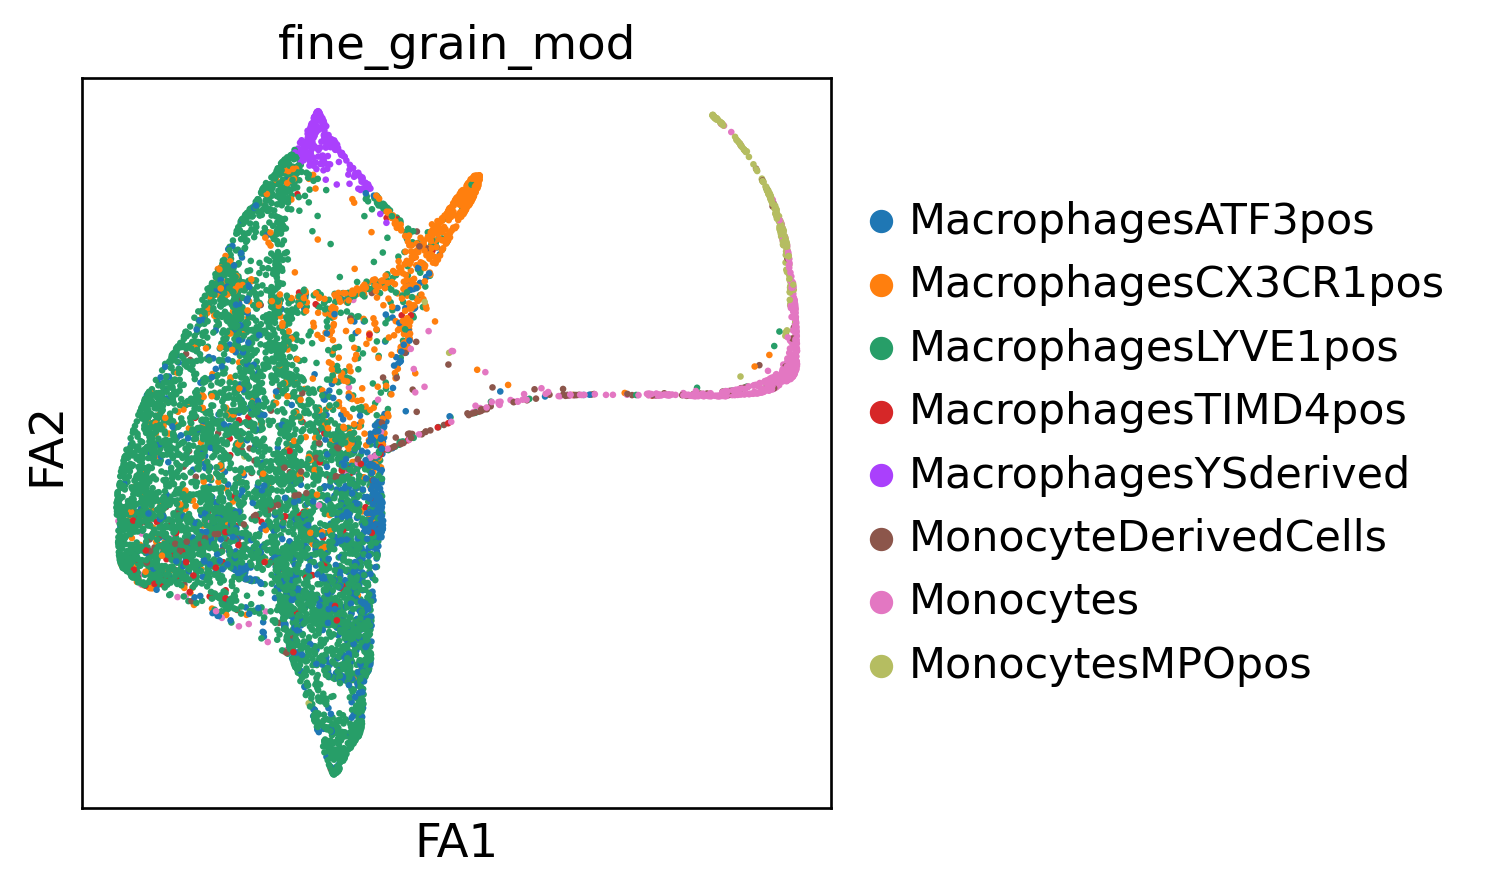

In [11]:
sc.pl.draw_graph(adata,color=["fine_grain_mod"],color_map="RdBu_r",wspace=0.7,show=False)

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


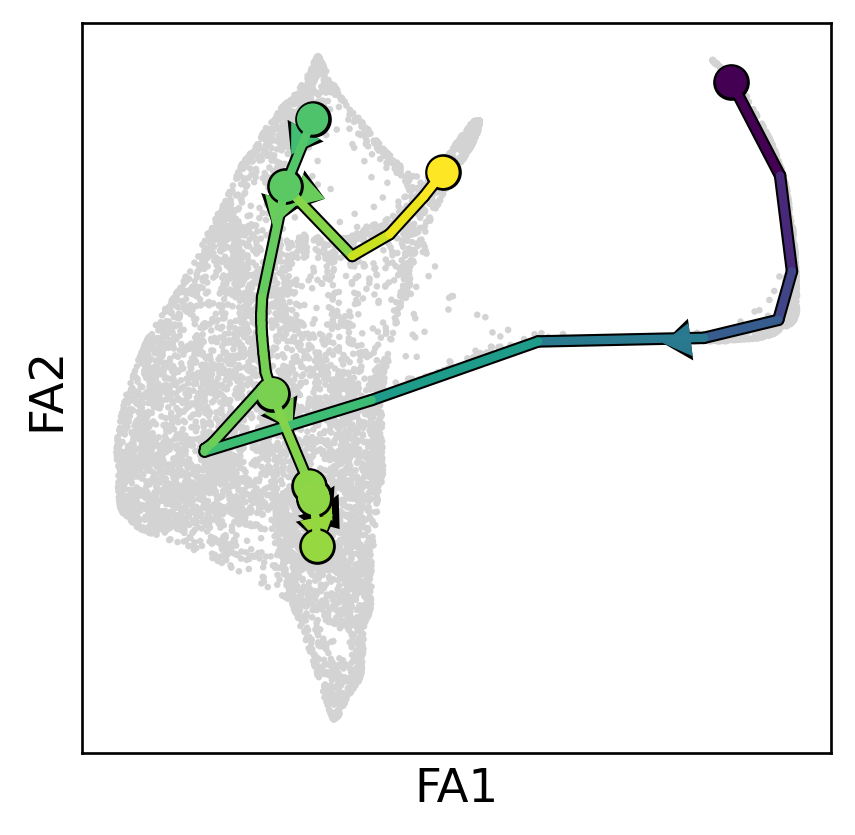

In [12]:
scf.pl.trajectory(adata,arrows=True,arrow_offset=2,scale_path=0.5)

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


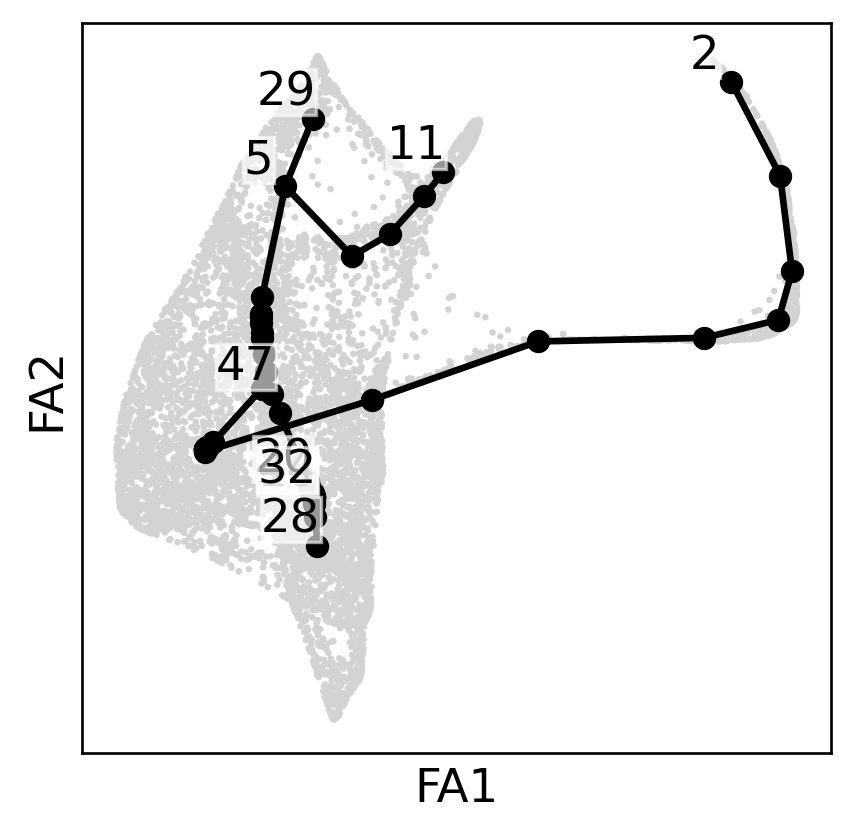

In [13]:
scf.pl.graph(adata,tips=True,forks=True)

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


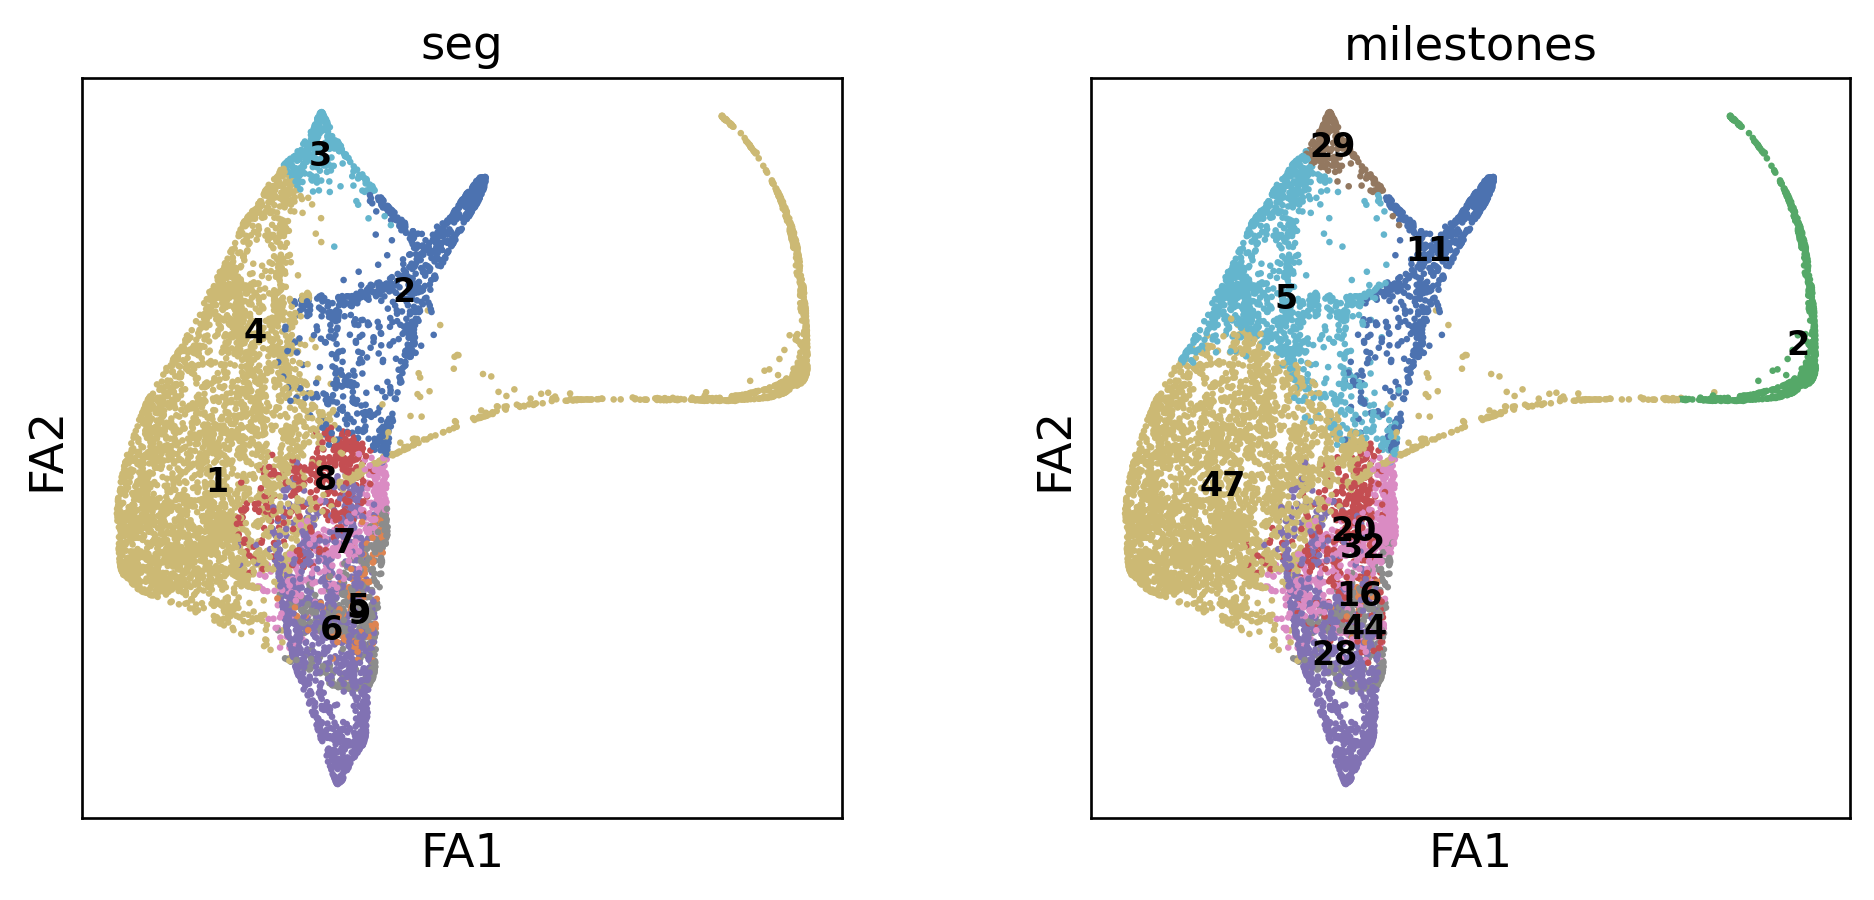

In [14]:
sc.pl.draw_graph(adata,color=["seg","milestones"],legend_loc='on data',legend_fontsize=10)

In [15]:
adata.obs.milestones.value_counts()

47    3001
5     1111
28     875
2      635
11     624
32     522
44     341
20     340
29     207
16      18
Name: milestones, dtype: int64

In [16]:
data = adata.uns['graph']['pp_seg']
data

,n,from,to,d
1,1,2,47,4.077848
2,2,5,11,0.691825
3,3,29,5,0.182072
4,4,5,47,0.361574
5,5,32,16,0.008786
6,6,20,28,0.129682
7,7,20,32,0.031062
8,8,47,20,0.170317
9,9,32,44,0.000772


In [ ]:
# save dataframe
data.to_csv('./graph_pp_seg.csv',index=None)

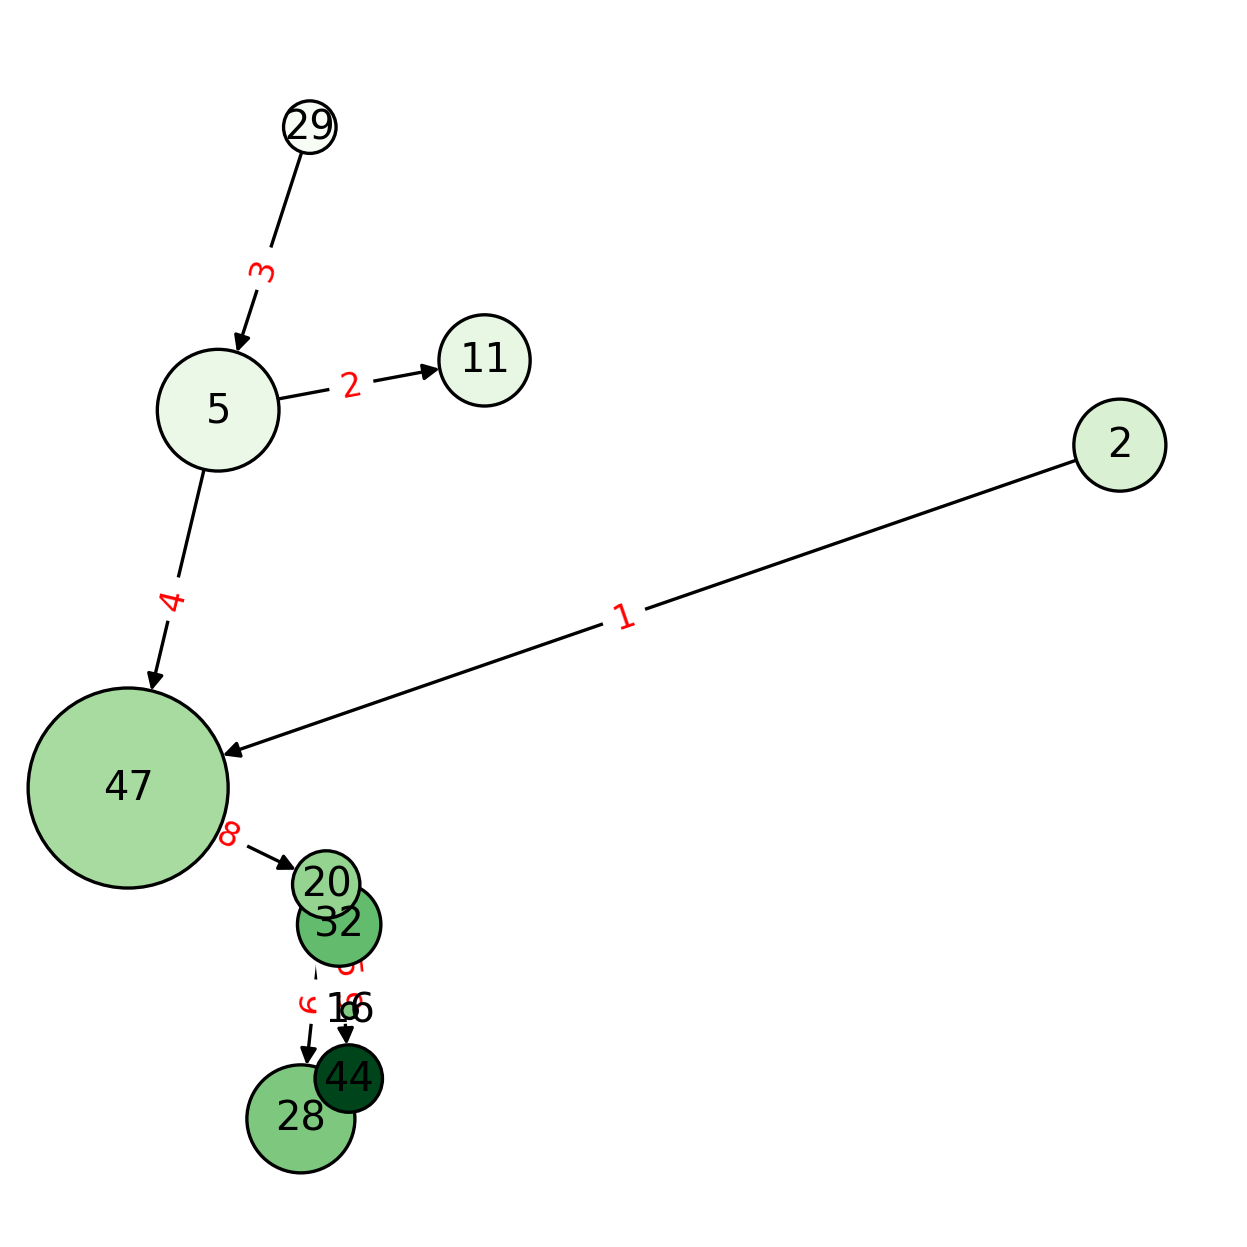

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx import *

# node color: age
# node size: population size

# Create a directed graph
G = nx.from_pandas_edgelist(data, 'from', 'to', create_using=nx.DiGraph())

# Creating a dictionary for edge labels
edge_labels = dict(zip(zip(data['from'], data['to']), data['n']))

# Position of the node
coord = pd.DataFrame(adata.obsm['X_draw_graph_fa'])
coord['milestones'] = list(adata.obs['milestones'])
coord = coord.groupby('milestones').mean()
coord_dict = {}
for milestone in coord.index:
    coord_dict[int(milestone)] = np.array(coord.loc[milestone])

# size of the node: cell number
size_dict_pre = adata.obs.milestones.value_counts().to_dict()
sizes = []
for key in list(G):
    sizes.append(size_dict_pre[str(key)])
sizes = np.array(sizes)

# color of the node: psendotime
adata.obs["week_continuous"] = [int(x.split('W')[0]) for x in adata.obs["week"]]
df = adata.obs[['week_continuous','milestones']]
df = df.groupby('milestones').mean()
df['week_scale'] = (df['week_continuous'] - df['week_continuous'].min())/(df['week_continuous'].max() - df['week_continuous'].min())
df.index = df.index.astype('int')
colors = np.array(df.loc[list(G)]['week_scale'])

# Draw the network
plt.figure(figsize=(5, 5))
nx.draw(G, coord_dict, with_labels=True, node_color=colors,
        node_size=sizes*1.2, arrows=True, edgecolors='black',
        cmap='Greens',
       )

# Add edge labels
nx.draw_networkx_edge_labels(G, coord_dict, edge_labels=edge_labels,
                             font_size=10, font_color='red'
                            )
plt.savefig(f"{figdir}/MoMP_milestone_segment_plots.pdf", bbox_inches="tight",dpi=300)
plt.show()